In [64]:
%reload_ext autoreload

%autoreload 2
import numpy as np
from models import lstm
import torch

In [65]:
# FILES TO CHANGE (This is where your sequence_nlp_harvey.zip etc is) 

NPY_INPUT_DIR = '/Users/ianmagnusson/IITUDND/data/extracted_features/combined_NLP/harvey/'

In [66]:
# load data from files

X_seq_tfidf_train = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_train.npz')
X_seq_tfidf_test = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_test.npz')


X_seq_glove_train = np.load(NPY_INPUT_DIR + 'X_seq_glove_train.npz')
X_seq_glove_test = np.load(NPY_INPUT_DIR + 'X_seq_glove_test.npz')

y_train = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_train.npy'))
y_test = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_test.npy'))

In [67]:
# format npz objects as lists of arrays again
X_tfidf_train = [ torch.Tensor(X_seq_tfidf_train[file]) for file in X_seq_tfidf_train.files]
X_tfidf_test = [ torch.Tensor(X_seq_tfidf_test[file]) for file in X_seq_tfidf_test.files]

X_glove_train = [ torch.Tensor(X_seq_glove_train[file]) for file in X_seq_glove_train.files]
X_glove_test = [ torch.Tensor(X_seq_glove_test[file]) for file in X_seq_glove_test.files]

In [68]:
# build lists with features concatenated

from sklearn.preprocessing import StandardScaler

X_raw_train = []
for i in range(len(y_train)):
    file = X_seq_tfidf_train.files[i]
    X_raw_train.append(np.concatenate((X_seq_tfidf_train[file], X_seq_glove_train[file]), axis=1))

scaler = StandardScaler()
X_fit_train = np.concatenate(X_raw_train)
scaler.fit(X_fit_train)

X_train = [torch.Tensor(scaler.transform(X_i)) for X_i in X_raw_train]

X_test = []
for i in range(len(y_test)):
    file = X_seq_tfidf_test.files[i]
    X_test.append(torch.Tensor(scaler.transform(np.concatenate((X_seq_tfidf_test[file], X_seq_glove_test[file]), axis=1))))


In [69]:
# build and train model

model = lstm.LSTM(input_dim=400, hidden_dim=128)

#model.learn(X_train, y_train)
#torch.save(model.state_dict(), 'norm_harvey_lstm.pt')

model.load_state_dict(torch.load('norm_harvey_lstm.pt'))
#model.eval()


<All keys matched successfully>

In [70]:
# evaluate
model.get_accuracy(X_test, y_test)

0.83125

R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = -0.05428796223446075
R2 score for bin 2 = 0.10904255319148937
R2 score for bin 3 = 0.11551155115511558
R2 score for bin 4 = -0.28352490421455956
R2 score for bin 5 = 0.31948051948051936
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


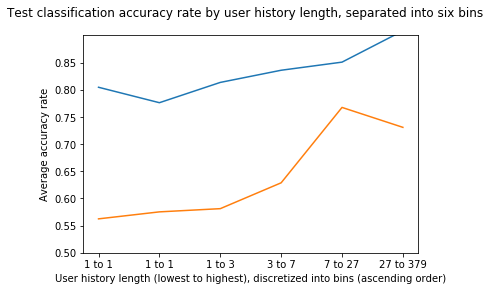

[0.8045112781954887,
 0.7761194029850746,
 0.8134328358208955,
 0.835820895522388,
 0.8507462686567164,
 0.9083969465648855]

In [71]:
model.get_accuracy_graph(X_test, y_test)

In [72]:
model.get_auc(X_test, y_test)


0.8288620083795109